# EDA IBM stock 1min ticks

## Takeouts -  december 29/2019
* The distribution of the difference of the time series has very long tails: see plot. This was expected; still very ugly.
* Created a very clean dataset with 'pastValues', 'currentValue', 'futureValue', 'deltaMinutes'. 
* The precision recall curve that we already have looks quite good: we trained one single time.

## Takeouts -  december 30/2019
* FINISH ASAP AND CLOSE THE NOTEBOOK: Plot a precision recall curve with several(monthly/weekly) training batches

## To do

* There is a delicate issue about rescaling before training that needs to be fixed asap.
* Turn the code that produces the 'clean' data set into a more reusable one
* The current version of the target is not very realistic.
* Need a more elaborated way of looking at histograms: the tails don't let me see anything: those tails are a huge concern.
* Look out for sklearn methods to do crossvalidation in our setting: do not reinvent the wheel.

## Questions:
* Data provider (currently using sample (adjusted) data from Kibot)
* How can I authomatize making orders, is there an api? how does this even work in real life?
* Cost per order
* Latency issues to be aware of.
* How/at what point can we know if we are `moving the market` too much?

In [177]:
cd ~/Desktop/MyProjects/moneyManager/

/Users/lduque/Desktop/MyProjects/moneyManager


In [178]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import plot_precision_recall_curve

In [179]:
# only loading some rows
names = ['Date', 'Time', 'Open', 'High', 'Low', 'Close', 'Volume']
df = pd.read_csv('data/sampleKibotData/minuteIntraday/IBM_adjusted.txt', header=None, names=names, nrows=200000)
df['DateTime'] = df.Date+' '+df.Time
df.DateTime = pd.to_datetime(df.DateTime,infer_datetime_format=True) 
ds = df[['DateTime', 'Open']].copy()

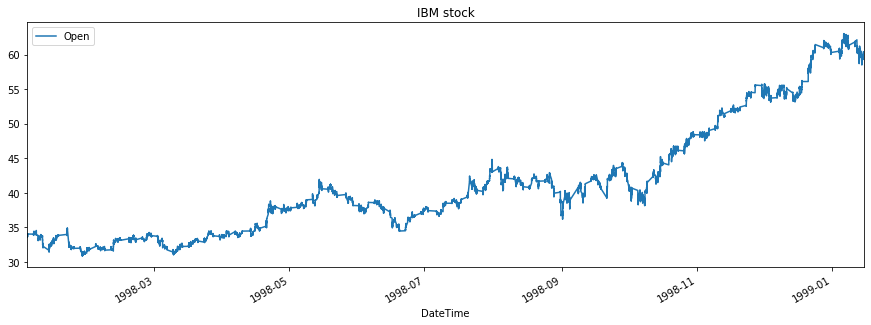

In [180]:
ds.set_index('DateTime').plot(figsize=(15,5), title='IBM stock');

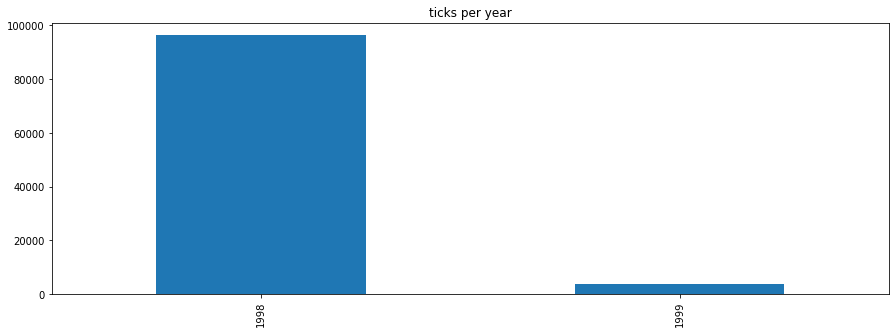

In [181]:
ds.DateTime.apply(lambda x: x.year).value_counts().sort_index().plot.bar(figsize=(15, 5), title='ticks per year');

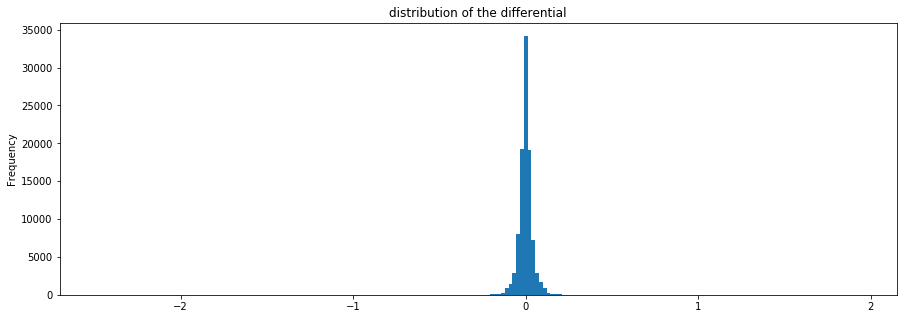

In [182]:
ds.Open.diff().plot.hist(bins=200, figsize=(15,5), title= 'distribution of the differential');

In [183]:
windowSize = 5
dsPast = pd.concat([ds.Open.shift(i) for i in range(windowSize, 0, -1)], axis=1).apply(lambda x: list(x), axis=1)
dsPresent = ds.Open
dsFuture = pd.concat([ds.Open.shift(i) for i in range(-1, -windowSize-1, -1)], axis=1).apply(lambda x: list(x), axis=1)
deltaMinutes = (ds.DateTime.shift(-windowSize) - ds.DateTime.shift(windowSize)).apply(lambda x: x.seconds)//60

In [184]:
dg = pd.concat([ds.DateTime, dsPast, dsPresent, dsFuture, deltaMinutes], axis=1)
dg.columns = ['DateTime', 'pastValues', 'currentValue', 'futureValue', 'deltaMinutes']
dg = dg.set_index('DateTime')
dg['target']=(dg.futureValue.apply(lambda x: max(x))>dg.currentValue)
dg=dg[dg.deltaMinutes==10.0]
dg.head()

,pastValues,currentValue,futureValue,deltaMinutes,target
DateTime,,,,,
1998-01-02 09:35:00,"[33.69, 33.65, 33.67, 33.67, 33.65]",33.67,"[33.67, 33.65, 33.65, 33.65, 33.67]",10.0,False
1998-01-02 09:36:00,"[33.65, 33.67, 33.67, 33.65, 33.67]",33.67,"[33.65, 33.65, 33.65, 33.67, 33.69]",10.0,True
1998-01-02 09:37:00,"[33.67, 33.67, 33.65, 33.67, 33.67]",33.65,"[33.65, 33.65, 33.67, 33.69, 33.73]",10.0,True
1998-01-02 09:38:00,"[33.67, 33.65, 33.67, 33.67, 33.65]",33.65,"[33.65, 33.67, 33.69, 33.73, 33.69]",10.0,True
1998-01-02 09:39:00,"[33.65, 33.67, 33.67, 33.65, 33.65]",33.65,"[33.67, 33.69, 33.73, 33.69, 33.77]",10.0,True


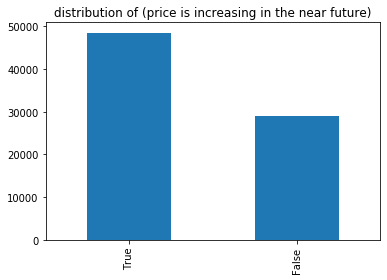

In [185]:
dg.target.value_counts().plot.bar(title='distribution of (price is increasing in the near future)');

In [186]:
X = pd.concat([dg.pastValues.apply(lambda x:pd.Series(x)), dg.currentValue, dg.target], axis=1)
y = X.pop('target')

In [188]:
# rescaling the dataframe
X = X.div(X.currentValue, axis=0)
X.drop(columns='currentValue')

,0,1,2,3,4
DateTime,,,,,
1998-01-02 09:35:00,1.000594,0.999406,1.000000,1.000000,0.999406
1998-01-02 09:36:00,0.999406,1.000000,1.000000,0.999406,1.000000
1998-01-02 09:37:00,1.000594,1.000594,1.000000,1.000594,1.000594
1998-01-02 09:38:00,1.000594,1.000000,1.000594,1.000594,1.000000
1998-01-02 09:39:00,1.000000,1.000594,1.000594,1.000000,1.000000
...,...,...,...,...,...
1999-01-15 13:54:00,0.999003,0.999336,0.999668,0.999668,0.999668
1999-01-15 13:55:00,0.999668,1.000000,1.000000,1.000000,1.000332
1999-01-15 13:56:00,0.999668,0.999668,0.999668,1.000000,0.999668


## A precision recall-curve with only one training split.

In [52]:
# temporal split of train/test
trainPercentage = 20
testBegins = (len(X)*trainPercentage)//100
Xtrain, ytrain = X[:testBegins], y[:testBegins]
Xtest, ytest = X[testBegins:], y[testBegins:]

In [102]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
parameters = {
    'min_samples_leaf' : [10, 20, 100],
    'max_depth': [5, 10, 20],
    'n_estimators': [10, 20, 100],   
    'max_features': ['sqrt']
}

regr = RandomForestClassifier(class_weight='balanced')
grid = GridSearchCV(regr, parameters, cv=2, scoring='average_precision')
grid.fit(Xtrain, ytrain)
model = grid.best_estimator_

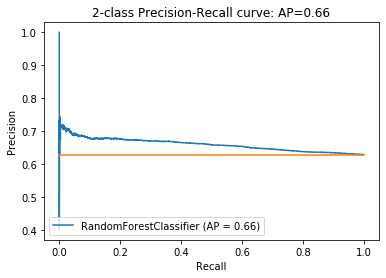

In [54]:
base_rate = sum(ytest)/len(ytest)
ypredicted=model.predict_proba(Xtest)[:,1]
average_precision = average_precision_score(ytest, ypredicted)
disp = plot_precision_recall_curve(model, Xtest, ytest)
disp.ax_.set_title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
plt.plot([0, 1], [base_rate, base_rate]);

# A precision-recall curve with multiple training batches

In [189]:
X = pd.concat([dg.pastValues.apply(lambda x:pd.Series(x)), dg.currentValue, dg.target], axis=1)
firstTimeStamp=X.index[0]
first_day = datetime(firstTimeStamp.year, firstTimeStamp.month, firstTimeStamp.day)
X['week']=pd.Series(X.index).apply(lambda x: (datetime(x.year, x.month, x.day)-first_day).days//7).values

In [166]:
# notice that for the week zero we wont have a model.
trainSets = [X[X.week==w] for w in X.week.unique()]
trainTestBarches = [(None, None, None, None)]+[(trainSets[i].drop(columns='target'),trainSets[i].target,trainSets[i+1].drop(columns='target'),trainSets[i+1].target) for i in range(len(trainSets)-1)]
models = [None] + [GridSearchCV(regr, parameters, cv=2, scoring='average_precision') for _ in range(len(trainSets)-1)]

In [173]:
Xtrain, ytrain, Xtest, ytest = trainTestBarches[1]

In [175]:
Xtrain # notice: week should not be in the model, but its ok for now

,0,1,2,3,4,currentValue,week
DateTime,,,,,,,
1998-01-02 09:35:00,33.69,33.65,33.67,33.67,33.65,33.67,0
1998-01-02 09:36:00,33.65,33.67,33.67,33.65,33.67,33.67,0
1998-01-02 09:37:00,33.67,33.67,33.65,33.67,33.67,33.65,0
1998-01-02 09:38:00,33.67,33.65,33.67,33.67,33.65,33.65,0
1998-01-02 09:39:00,33.65,33.67,33.67,33.65,33.65,33.65,0
...,...,...,...,...,...,...,...
1998-01-08 15:53:00,33.59,33.59,33.59,33.57,33.59,33.63,0
1998-01-08 15:54:00,33.59,33.59,33.57,33.59,33.63,33.67,0
1998-01-08 15:55:00,33.59,33.57,33.59,33.63,33.67,33.65,0


In [168]:
for i in range(1, len(models)):
    print(i)
    Xtrain, ytrain, Xtest, ytest = trainTestBarches[i]
    models[i].fit(Xtrain, ytrain)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54


In [171]:
# this function is worth saving somewhere !
def indexedModelEvaluation(x):
    row = x.copy()
    week = row['week']
    row = row.drop('target')
    model = models[week]
    if model==None:
        return np.nan
    row = [list(row)]
    print(row)
    return model.predict_proba(row)[0][1]

In [172]:
ypredicted = X.apply(indexedModelEvaluation,axis=1)

[[33.63, 33.63, 33.71, 33.81, 33.77, 33.73]]
[[33.63, 33.63, 33.71, 33.81, 33.77, 33.73]]


ValueError: ('Number of features of the model must match the input. Model n_features is 7 and input n_features is 6 ', 'occurred at index 1998-01-09 09:36:00')